# Diffusion models for ultrasound image generation

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
from usbmd import log
from usbmd.models.diffusion import DiffusionModel
from usbmd.ops import Pipeline, ScanConvert
from usbmd.visualize import plot_image_grid, set_mpl_style
from usbmd import init_device

init_device()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-------------------GPU settings-------------------
     memory
GPU        
0        1018
1       10852
2       10852
3       11011
4       11011
5       11011
6       11011
7       11011
Selecting 1 GPU based on available memory.
Selected GPU 3 with Free Memory: 11011.00 MiB
Hiding GPUs [0, 1, 2, 4, 5, 6, 7] from the system.
--------------------------------------------------


'gpu:0'

In [2]:
presets = list(DiffusionModel.presets.keys())
log.info(f"Available built-in usbmd presets for DiffusionModel: {presets}")

model = DiffusionModel.from_preset("diffusion-echonet-dynamic")

## Prior sampling
prior_samples = model.sample(n_samples=16, n_steps=90, verbose=True)

usbmd: Available built-in usbmd presets for DiffusionModel: ['diffusion-echonet-dynamic']
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step


In [3]:

pipeline = Pipeline([ScanConvert(order=1, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
prior_samples = keras.ops.squeeze(prior_samples, axis=-1)

parameters = pipeline.prepare_parameters(**parameters)
processed_batch = pipeline(data=prior_samples, **parameters)["data"]

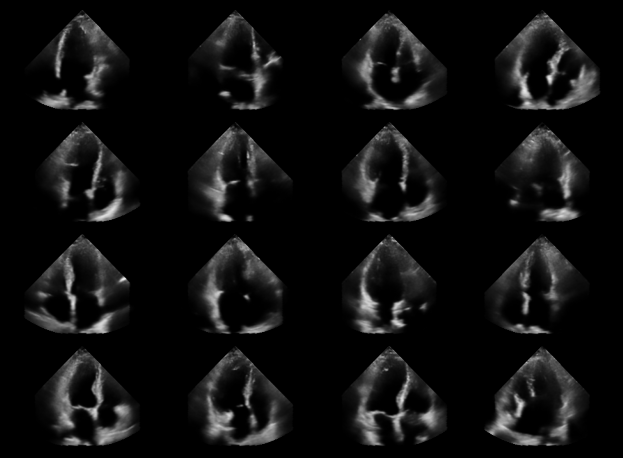

In [4]:
fig, _ = plot_image_grid(
    processed_batch, vmin=-1, vmax=1,
)
fig.savefig("diffusion_prior_samples.png", dpi=200, bbox_inches="tight")